In [301]:
""" Classes and examples for searching for flights using SkyPicker. """
from __future__ import unicode_literals, absolute_import, generators, \
    print_function

import requests
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import DataFrame 

In [302]:
""" SkyPicker API reference that may help figure out different search parameters """
# https://ç.docs.apiary.io/#reference/flights/flights/get?console=1
""" More exhaustive reference for the API """
# https://github.com/SScorp/Skypicker-apiary/blob/master/apiary.apib
""" All possible parameters that can be fed to flight search """
# ## flights [/flights{?flyFrom,to,dateFrom,dateTo,longitudeFrom,
# latitudeFrom,radiusFrom,longitudeTo,latitudeTo,radiusTo,
# daysInDestinationFrom,daysInDestinationTo,returnFrom,returnTo,
# maxFlyDuration,typeFlight,passengers,adults,children,infants,
# flyDays,flyDaysType,returnFlyDays,returnFlyDaysType,oneforcity,
# onlyWorkingDays,onlyWeekends,one_per_date,directFlights,locale,partner,partner_market,v,xml,curr,
# locale,price_from,price_to,dtimefrom,dtimeto,atimefrom,atimeto,returndtimefrom,returndtimeto,
# returnatimefrom,returnatimeto,stopoverfrom,stopoverto,maxstopovers,connectionsOnDifferentAirport,
# returnFromDifferentAirport,returnToDifferentAirport,ref_tasks,innerLimit,selectedAirlines,
# selectedStopoverAirports,selectedAirlinesExclude,selectedStopoverAirportsExclude,booking_token,offset,limit,sort,asc}]
""" The code is largely based on the code from this github repository. Code for other flight ticket APIs is also available there
"""
# https://github.com/kjam/python_flight_search

u' The code is largely based on the code from this github repository. Code for other flight ticket APIs is also available there\n'

In [303]:
class SkyPickerApi(object):
    """ SkyPicker API. """
    def __init__(self):
        """ Initializes the API object with URL attributes. """
        self.base_url = 'https://api.skypicker.com/'
        self.path = ''
        self.param_str = ''

    @property
    def full_url(self):
        """ Returns the full URL for requesting the data. """
        return '{}{}{}'.format(self.base_url, self.path, self.param_str)

    def get_request(self):
        """ Requests the API endpoint and returns the response """
        headers = {'content-type': 'application/json'}
        resp = requests.get(self.full_url, headers=headers)
        return resp.json()

    def search_places(self, place_name, locale=None):
        """ Finds matching place API ids to use for searches.
        :param place_name: string of the place name to search for
        :kwarg locale: two letter lowercase locale string
        returns JSON response
        """
        self.path = 'places'
        self.param_str = '?term={}'.format(place_name)
        if locale:
            self.param_str += '&locale={}'.format(locale)
        return self.get_request()

    def search_flights(self, origin, destination, start_date, end_date, return_date_from, return_date_to, 
                       num_passengers, currency, typeFlight, connections):
        """ Searches for flights given a time range and origin and destination.
        :param origin: string representing the ID or IATA
        :param destination: string representing the ID or IATA
        :param start_date: datetime representing first possible travel date
        :param end_date: datetime representing last possible travel date
        :param return_date_from: datetime representing first possible return date
        :param return_date_to: datetime representing last possible return date
        :param num_passengers: integer
        :param currency: name of currency - e.g. USD or EUR
        :param typeFlight: oneway for one-way flights, round for two-way flights
        returns response in JSON format - list of dictionaries
        """
        """ Searching through flights"""
        self.path = 'flights'
        """ Setting main search parameters """
        self.param_str = '?flyFrom=' + \
            '{}&to={}&dateFrom={}&dateTo={}&returnFrom={}&returnTo={}&passengers={}&curr={}&typeFlight={}&maxstopovers={}'.format(
                origin, destination, start_date.strftime('%d/%m/%Y'), end_date.strftime('%d/%m/%Y'), 
                return_date_from.strftime('%d/%m/%Y'), return_date_to.strftime('%d/%m/%Y'),
                num_passengers, currency, typeFlight, connections)
        """ SkyPicker API. """
        """ Sending request to the API - if no flights satisfy the search, this object will have no entries"""
        resp = self.get_request()
        """ Empty List of Flights """
        flights = []
        """ For loop that fills the list of flights based on the API request output"""
        """ Data Reporting Section of the Code """
        for flight in resp.get('data'):
            """ For each flight from resp we take different info"""
            flight_info = {
                'price': flight.get('price'),
                'currency': resp.get('currency'),
                'legs': []
            }
            """ Each flight has >=1 legs, for each leg we extract and compute some info"""
            """Local Departure and Arrival Time are Reported Here"""  
            for route in flight['route']:
                flight_info['legs'].append({
                    'carrier': route['airline'], 
                    'departure': datetime.fromtimestamp(
                        route.get('dTime')),
                    'arrival': datetime.fromtimestamp(
                        route.get('aTime')),
                    'duration': (datetime.utcfromtimestamp(
                        route.get('aTimeUTC')) - datetime.utcfromtimestamp(
                        route.get('dTimeUTC'))).total_seconds()/3600,
                    'from': '{} ({},longitude:{},latitude:{})'.format(route['cityFrom'], route['flyFrom'], route['lngFrom'], route['latFrom']),
                    'to': '{} ({},longitude:{},latitude:{})'.format(route['cityTo'], route['flyTo'], route['lngTo'], route['latTo']), 
                })
            flight_info['carrier'] = ', '.join(set([c.get('carrier') for c
                                                    in flight_info['legs']]))
            flights.append(flight_info)
        return flights

In [304]:
""" When you are dealing with a class, you have to initialize an instant of this class. This line accomplishes this"""
inst = SkyPickerApi()

In [305]:
""" After initializing an intant you can call functions that are included in the class. In this case we are searching 
for two-way flights from JFK to SFO that depart on March 29 and return on March 31. """
res = inst.search_flights('SFO', 'YYZ', datetime(2018,8,15), datetime(2018,8,15), 
                           datetime(2018,8,23), datetime(2018,8,23), 1, 'USD', 'oneway', 2)


In [306]:
""" This is the summary of information about the first flight"""
res[0]

{u'carrier': u'DL',
 u'currency': u'USD',
 u'legs': [{u'arrival': datetime.datetime(2018, 8, 15, 22, 43),
   u'carrier': u'DL',
   u'departure': datetime.datetime(2018, 8, 15, 15, 15),
   u'duration': 4.466666666666667,
   u'from': u'San Francisco (SFO,longitude:-122.39167,latitude:37.618889)',
   u'to': u'Cincinnati (CVG,longitude:-84.667778,latitude:39.048889)'},
  {u'arrival': datetime.datetime(2018, 8, 16, 1, 50),
   u'carrier': u'DL',
   u'departure': datetime.datetime(2018, 8, 16, 0, 20),
   u'duration': 1.5,
   u'from': u'Cincinnati (CVG,longitude:-84.667778,latitude:39.048889)',
   u'to': u'Toronto (YYZ,longitude:-79.630556,latitude:43.677222)'}],
 u'price': 179}

In [307]:
carrier = []
for x in res:
    for i in x['legs']:
        if i['carrier'] not in carrier:
            carrier.append(i['carrier'])                     
print(carrier)

[u'DL', u'AS', u'UA', u'WS', u'AC', u'B6', u'SY']


In [308]:
""" Empty List of flight durations """
duration = []
""" Running a for loop to complete the total scheduled duration of all flight legs"""
for x in res:
    dur = 0
    """ Looping over individual flight legs for each flight to extract flight time"""
    for i in x['legs']:
        dur += i['duration']
    duration.append(dur)
""" Empty List of Flight Prices """
price = []
""" Looping over flights to get out the price for each flight """
for x in res:
    price.append(x['price'])


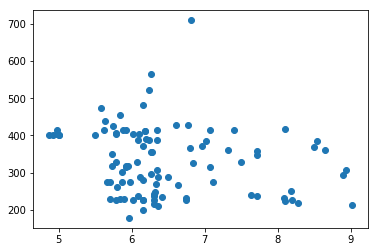

In [309]:
plt.scatter(duration, price)
# plt.xlim(12, 19)
# plt.ylim(200, 3000)
plt.show()

In [310]:
depature_time = [] 
arrival_time = []
for x in res: 
    depature_time.append(x['legs'][0]['departure'].strftime('%H:%M')) 
    arrival_time.append(x['legs'][-1]['arrival'].strftime('%H:%M'))

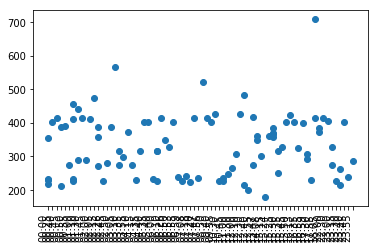

In [311]:
plt.scatter(depature_time, price) 
plt.gcf().autofmt_xdate(rotation = 90) 
plt.show()

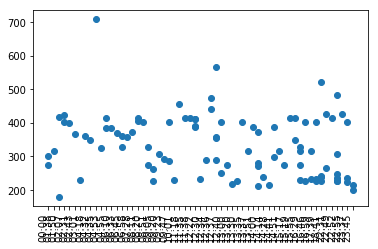

In [312]:
plt.scatter(arrival_time, price) 
plt.gcf().autofmt_xdate(rotation = 90) 
plt.show()

In [313]:
for x in res:
    x['departure'] = x['legs'][0]['departure'].strftime('%H:%M')
    x['arrival'] = x['legs'][-1]['arrival'].strftime('%H:%M')
data = DataFrame(res) 

In [314]:
data.describe()

,price
count,100.000000
mean,332.660000
std,91.089613
min,179.000000
25%,247.250000
50%,326.500000
75%,402.250000
max,709.000000


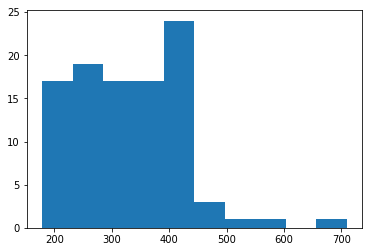

In [315]:
plt.hist(price) 
plt.show()